### 리빙랩 보고서용 데이터 분석 페이지

1. 문제 인식
2. 데이터 수집
3. 데이터 전처리
4. 데이터 분석
5. 시각화 및 해석

### 1. 문제 인식
- 재생에너지 사용을 늘려야하지만 시스템 상 제약이 많다
- ESS 설치를 통해 재생에너지 사용을 늘리고자 함
- 학교, 공장, 주택 등과 재생에너지 발전사가 직접 거래하는 거 어때
- 기존 PPA 문제점 : 1) 장기계약, 2) 수요와 공급 시간대가 안 맞음



### 2. AI를 통한 시간대별 에너지 사용량 분석
- 데이터 : KT 데이터 - 공장 사용가
- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 3. 월별 학교 에너지 사용량 분석
- 데이터 : 국토교통부 - 경북대학교 전력 사용량
- 목표 : 학교의 에너지 사용량을 분석하여 ESS 용량 확인
- 기간 : 2020년 4월 ~ 2024년 2월



In [2]:
data_elec = pd.read_csv('../DATA/elec_data.csv')
data_elec.head()

,useYm,useQty
0,201101,194.0
1,201102,188.0
2,201103,267.0
3,201104,289.0
4,201105,284.0


In [3]:
# useYm -> datetime format
data_elec['useYm'] = pd.to_datetime(data_elec['useYm'], format='%Y%m')

# over 2020-01
data_elec = data_elec[data_elec['useYm'] >= '2020-11']

data_elec['Year'] = data_elec['useYm'].dt.year
data_elec['Month'] = data_elec['useYm'].dt.month

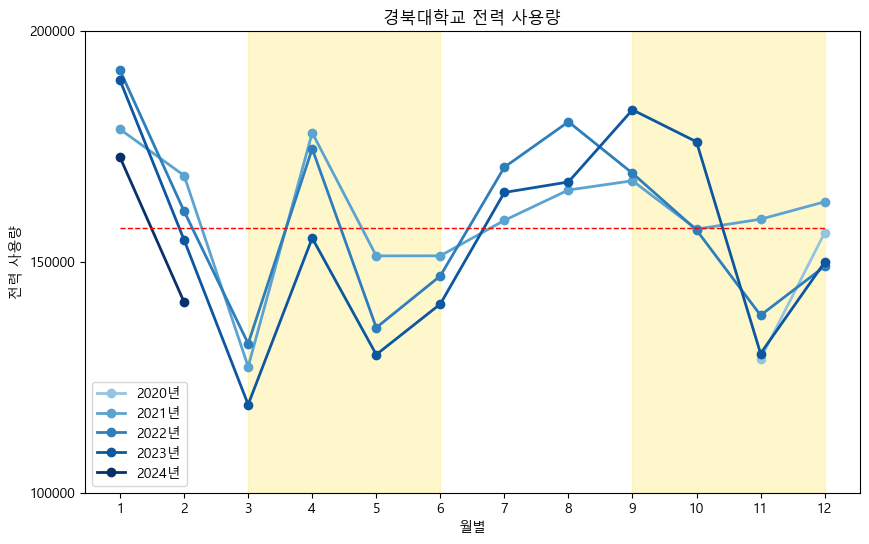

In [4]:
import matplotlib.cm as cm

# Korean font
plt.rc('font', family='Malgun Gothic')

# colormap 생성
colors = cm.Blues(np.linspace(0.4, 1, 5))

plt.figure(figsize=(10, 6))
for i, color in zip(range(2020, 2025), colors):
    plt.plot(data_elec[data_elec['Year'] == i].groupby('Month')['useQty'].sum(), label=f'{i}년', marker='o', linestyle='-', linewidth=2, color=color)
plt.hlines(data_elec['useQty'].mean(), 1, 12, color='red', linestyle='--', linewidth=1)
plt.xlabel('월별')
plt.xticks(np.arange(1, 13))
plt.ylabel('전력 사용량')
plt.yticks(np.arange(100000, 250000, 50000))
# 노란색 배경
plt.axvspan(3, 6, color='gold', alpha=0.2)
plt.axvspan(9, 12, color='gold', alpha=0.2)
plt.title('경북대학교 전력 사용량')
plt.legend()
plt.show()

### 해석
1. 일정한 패턴의 에너지 사용량을 보임
2. 여름, 겨울 계절에 사용량이 높음
3. 4월 사용량이 유난히 높은 이유는, 중간고사와 기온변동으로 판단됨

### 결론
ESS 설치 시 한달 용량을 고려하여 설치


In [30]:
data_pred = pd.DataFrame({'Month': np.arange(1, 13), '2021': data_elec[data_elec['Year'] == 2021]['useQty'].values})

# 2022, 2023, 2024년 추가
for i in range(2022, 2024):
    data_pred[f'{i}'] = data_elec[data_elec['Year'] == i]['useQty'].values

# data_2024 = data_elec[data_elec['Year'] == 2024] 에 나머지 월을 NaN으로 채워서 추가
data_2024 = data_elec[data_elec['Year'] == 2024]['useQty'].values
data_2024 = np.append(data_2024, np.repeat(np.nan, 12 - len(data_2024)))
data_pred['2024'] = data_2024
data_pred.set_index('Month', inplace=True)

In [33]:
data_pred

,2021,2022,2023,2024
Month,,,,
1,178661.0,191391.0,189248.0,172577.0
2,168657.0,160922.0,154699.0,141258.0
3,127284.0,132289.0,119090.0,NaN
4,177906.0,174460.0,155122.0,NaN
5,151263.0,135723.0,129896.0,NaN
6,151278.0,146926.0,140844.0,NaN
7,158952.0,170461.0,164994.0,NaN
8,165521.0,180289.0,167263.0,NaN
9,167524.0,169151.0,182880.0,NaN


### 3. 재생에너지 발전량

- 출처 : https://www.data.go.kr/data/15065269/fileData.do

- 기간 : 2023-06-01 ~ 2023-11-30
- 지역 : 전국
- 구간 : 시간별
- 데이터 : 태양광 발전량, 풍력 발전량
- 데이터 형식 : csv

#### 추출할 데이터
1. 지자체별 평균 발전량
2. 대구시 시간대별 발전량 그래프 (태양광, 풍력, a=0.5)

In [100]:
data_re = pd.read_csv('../DATA/RE_data.csv', encoding='cp949')
data_re.head()

C:\Users\HOME\AppData\Local\Temp\ipykernel_3304\1406610933.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_re = pd.read_csv('../DATA/RE_data.csv', encoding='cp949')


,연도,월,일,시간,지역,태양광발전량(MWh)
0,2022,12,1,1,경기도,1.51
1,2022,12,1,2,경기도,0.14
2,2022,12,1,3,경기도,0
3,2022,12,1,4,경기도,0
4,2022,12,1,5,경기도,0


In [102]:
data_re['태양광발전량(MWh)'] = pd.to_numeric(data_re['태양광발전량(MWh)'], errors='coerce').fillna(0)
data_re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148920 entries, 0 to 148919
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   연도           148920 non-null  int64  
 1   월            148920 non-null  int64  
 2   일            148920 non-null  int64  
 3   시간           148920 non-null  int64  
 4   지역           148920 non-null  object 
 5   태양광발전량(MWh)  148920 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 6.8+ MB


In [103]:
# '지역'에서 경상북도와 대구시만 추출
data_re_k = data_re[data_re['지역'] == '경상북도']
data_re_t = data_re[data_re['지역'] == '대구시']
data_re_k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 72 to 148607
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   연도           8760 non-null   int64  
 1   월            8760 non-null   int64  
 2   일            8760 non-null   int64  
 3   시간           8760 non-null   int64  
 4   지역           8760 non-null   object 
 5   태양광발전량(MWh)  8760 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 479.1+ KB


In [116]:
# 시간대별 태양광 발전량
re_mean_k = data_re_k.groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t = data_re_t.groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_k

# 3~6월, 9~12월 시간대별 태양광 발전량
data_re_spring = data_re[(data_re['월'] >= 3) & (data_re['월'] <= 6)]
data_re_fall = data_re[(data_re['월'] >= 9) & (data_re['월'] <= 12)]
data_re_summer = data_re[(data_re['월'] >= 6) & (data_re['월'] <= 8)]
data_re_winter = data_re[(data_re['월'] >= 12) | (data_re['월'] <= 2)]

re_mean_k_spring = data_re_spring[data_re_spring['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_spring = data_re_spring[data_re_spring['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

re_mean_k_fall = data_re_fall[data_re_fall['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_fall = data_re_fall[data_re_fall['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

re_mean_k_summer = data_re_summer[data_re_summer['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_summer = data_re_summer[data_re_summer['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

re_mean_k_winter = data_re_winter[data_re_winter['지역'] == '경상북도'].groupby('시간')['태양광발전량(MWh)'].mean()
re_mean_t_winter = data_re_winter[data_re_winter['지역'] == '대구시'].groupby('시간')['태양광발전량(MWh)'].mean()

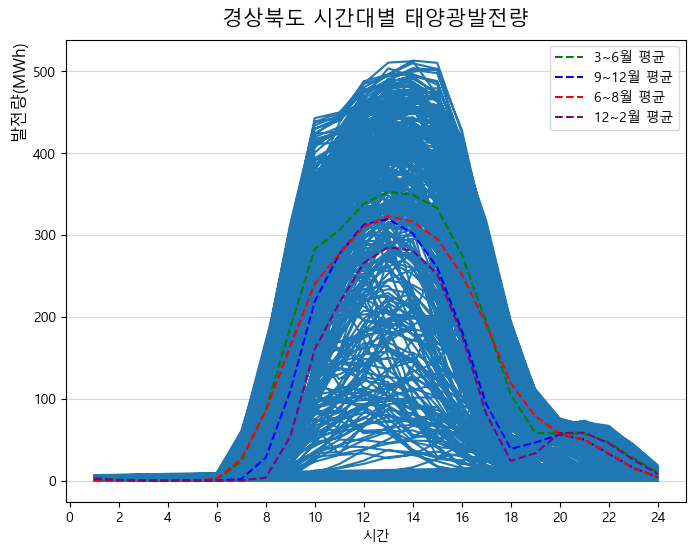

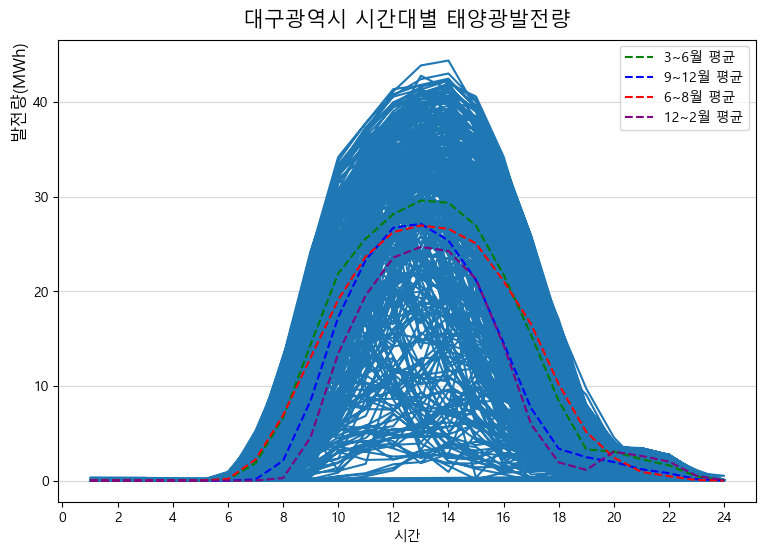

In [119]:
# plot
plt.figure(figsize=(8, 6))
plt.plot(data_re_k['시간'], data_re_k['태양광발전량(MWh)'])
plt.xlabel('시간')
plt.xticks(np.arange(0, 26, 2))
plt.ylabel('발전량(MWh)', fontsize=12, loc='top')
plt.title('경상북도 시간대별 태양광발전량', fontsize=15, pad=10)
plt.plot(re_mean_k_spring, label='3~6월 평균', linestyle='--', color='green')
plt.plot(re_mean_k_fall, label='9~12월 평균', linestyle='--', color='blue')
plt.plot(re_mean_k_summer, label='6~8월 평균', linestyle='--', color='red')
plt.plot(re_mean_k_winter, label='12~2월 평균', linestyle='--', color='purple')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

# plot (대구)
plt.figure(figsize=(9, 6))
plt.plot(data_re_t['시간'], data_re_t['태양광발전량(MWh)'])
plt.xlabel('시간')
plt.xticks(np.arange(0, 26, 2))
plt.ylabel('발전량(MWh)', fontsize=12, loc='top')
plt.title('대구광역시 시간대별 태양광발전량', fontsize=15, pad=10)
plt.plot(re_mean_t_spring, label='3~6월 평균', linestyle='--', color='green')
plt.plot(re_mean_t_fall, label='9~12월 평균', linestyle='--', color='blue')
plt.plot(re_mean_t_summer, label='6~8월 평균', linestyle='--', color='red')
plt.plot(re_mean_t_winter, label='12~2월 평균', linestyle='--', color='purple')
plt.legend()
plt.grid(True, axis='y', alpha=0.5)
plt.show()

In [122]:
# 월별 태양광 발전량 합계
re_sum_k = data_re_k.groupby('월')['태양광발전량(MWh)'].sum()
re_sum_t = data_re_t.groupby('월')['태양광발전량(MWh)'].sum()

print(re_sum_k)
print(re_sum_t)


월
1     64610.580000
2     66593.270000
3     91668.335366
4     91239.122886
5     95945.619600
6     98647.107514
7     78039.011228
8     84616.950380
9     74413.516671
10    88979.482358
11    71420.697986
12    51893.370000
Name: 태양광발전량(MWh), dtype: float64
월
1     5002.980000
2     5140.570000
3     6880.324131
4     7313.277742
5     7342.414849
6     7828.529685
7     6192.061019
8     6828.506205
9     5695.987505
10    6743.226129
11    5436.175538
12    4534.600000
Name: 태양광발전량(MWh), dtype: float64


#### 해석
1. 대구시의 최대발전량은 40, 평균 발전량은 ㅇㅇ
2. 경상북도의 최대발전량은 500, 평균 발전량은 ㅇㅇ
3. 시간대별 발전량 확인 (13시가 맥스)

#### 결론
1. 대구시의 